In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd


In [ ]:
# Load dataset
df = pd.read_csv('fer2013.csv')

# Check structure
print(df.columns)  # Should be ['emotion', 'pixels', 'usage']

Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [ ]:
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


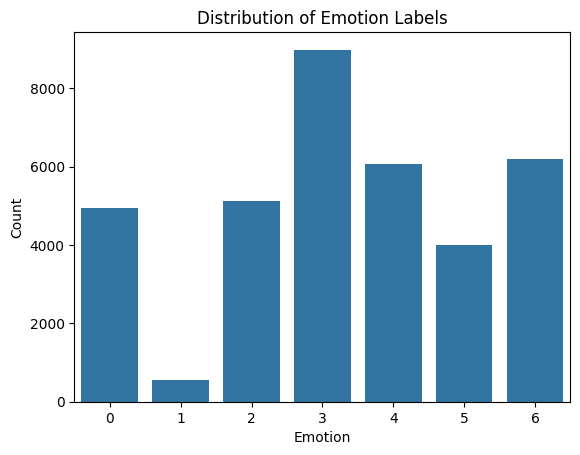

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt  # use plt, not pyplot directly

sns.countplot(x='emotion', data=df)  # assuming your DataFrame is called `data`
plt.title("Distribution of Emotion Labels")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


In [ ]:
import math
math.sqrt(len(df.pixels[0].split(' ')))


48.0

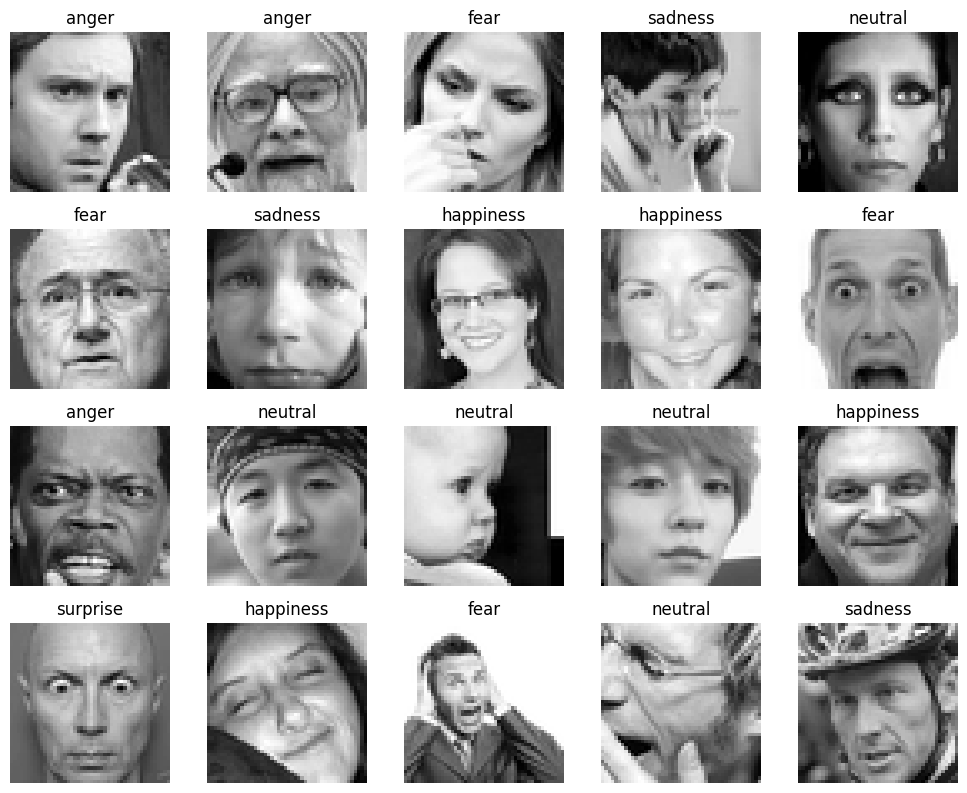

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    pixels = np.array(df['pixels'].iloc[i].split(), dtype='float32').reshape(48, 48)
    plt.imshow(pixels, cmap='gray')
    plt.title(emotion_labels[df['emotion'].iloc[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


# Preprocessing


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Settings
INTERESTED_LABELS = [3, 4, 6]  # happiness, sadness, neutral
LABEL_MAP = {3:0, 4:1, 6:2}    # remap labels to 0,1,2

# Load dataset
df = pd.read_csv('fer2013.csv')


In [ ]:
df.columns = [col.strip() for col in df.columns]
print(df.columns)


Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [ ]:
faces = []
labels = []
usages = []

for i, row in df.iterrows():
    try:
        emotion = int(row['emotion'])
        if emotion not in INTERESTED_LABELS:
            continue

        pixel_str = row['pixels']
        usage = row['Usage'].strip()

        pixels = np.array(pixel_str.split(), dtype='float32')
        if pixels.size != 48 * 48:
            print(f"Skipping row {i}: pixel size {pixels.size}")
            continue

        face = pixels.reshape(48, 48, 1) / 255.0
        faces.append(face)
        labels.append(LABEL_MAP[emotion])
        usages.append(usage)

    except Exception as e:
        print(f"Error at row {i}: {e}")
        continue


In [ ]:
# Convert to numpy arrays
faces = np.array(faces)
labels = np.array(labels)
usages = np.array(usages)

# One-hot encode labels
emotions = to_categorical(labels, num_classes=3)


In [ ]:
import pandas as pd

df = pd.read_csv('fer2013.csv')
print(f"Shape of DataFrame: {df.shape}")
print(f"First few columns: {df.columns.tolist()}")
print(df.head(3))


Shape of DataFrame: (35887, 3)
First few columns: ['emotion', 'pixels', 'Usage']
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training


# CNN


In [ ]:
X_train = faces[usages == 'Training']
y_train = emotions[usages == 'Training']

X_val = faces[usages == 'PublicTest']
y_val = emotions[usages == 'PublicTest']

X_test = faces[usages == 'PrivateTest']
y_test = emotions[usages == 'PrivateTest']

print(f"Train samples: {X_train.shape[0]}")
print(f"Val samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Train samples: 17010
Val samples: 2155
Test samples: 2099


In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if val_loss doesn't improve after 5 epochs
    restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.4729 - loss: 1.2211 - val_accuracy: 0.6302 - val_loss: 0.8247
Epoch 2/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6130 - loss: 0.8132 - val_accuracy: 0.6260 - val_loss: 0.7805
Epoch 3/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6667 - loss: 0.7227 - val_accuracy: 0.5745 - val_loss: 0.8810
Epoch 4/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6844 - loss: 0.6869 - val_accuracy: 0.6218 - val_loss: 0.8073
Epoch 5/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7142 - loss: 0.6456 - val_accuracy: 0.6784 - val_loss: 0.7078
Epoch 6/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7358 - loss: 0.5950 - val_accuracy: 0.6988 - val_loss: 0.6643
Epoch 7/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7593 - loss: 0.5504 - val_accuracy: 0.6817 - val_loss: 0.7199
Epoch 8/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7776 - loss: 0.5142 - val_accuracy: 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6934 - loss: 1.4136
Test accuracy: 0.71


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


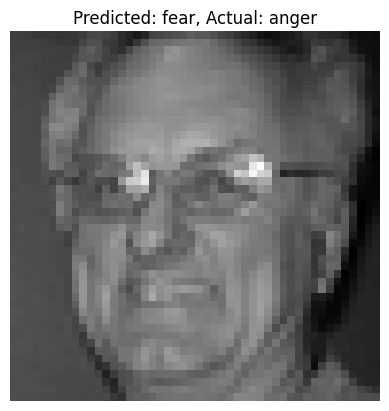

In [ ]:
import random

i = random.randint(0, len(X_test) - 1)
prediction = model.predict(np.expand_dims(X_test[i], axis=0))
predicted_label = emotion_labels[np.argmax(prediction)]
actual_label = emotion_labels[np.argmax(y_test[i])]

plt.imshow(X_test[i].squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
plt.axis('off')
plt.show()


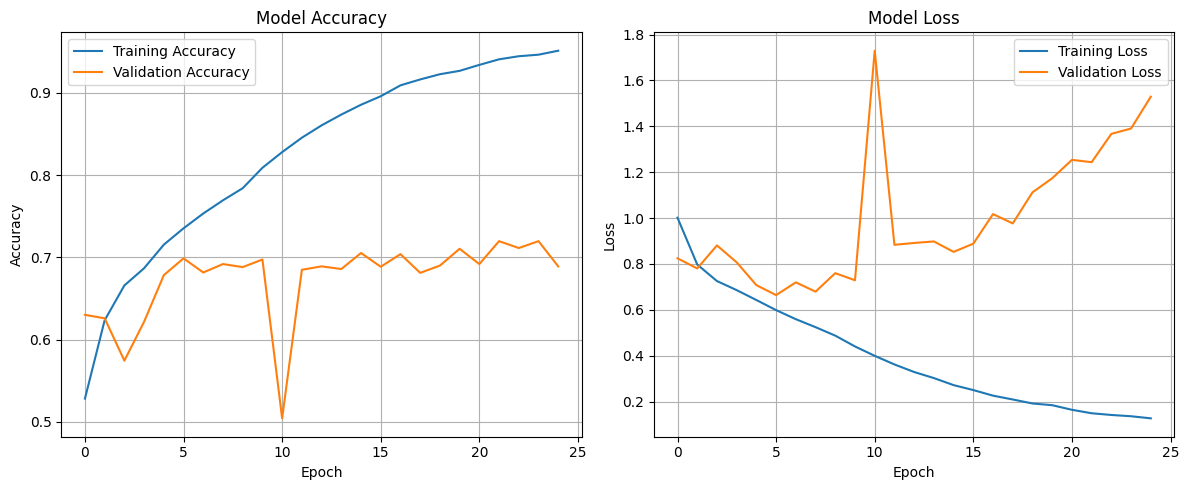

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

   happiness       0.86      0.83      0.84       879
     sadness       0.60      0.59      0.60       594
     neutral       0.62      0.66      0.64       626

    accuracy                           0.71      2099
   macro avg       0.69      0.69      0.69      2099
weighted avg       0.71      0.71      0.71      2099



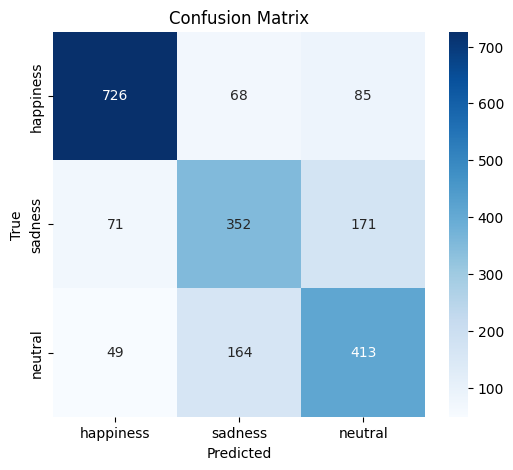

In [ ]:
# ✅ STEP 9: Evaluation
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=['happiness', 'sadness', 'neutral']))

# ✅ STEP 10: Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['happiness', 'sadness', 'neutral'],
            yticklabels=['happiness', 'sadness', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Transfer Learning

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # ✅ Fixed here

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical



In [17]:
INTERESTED_LABELS = [3, 4, 6]  # happiness, sadness, neutral
LABEL_MAP = {3: 0, 4: 1, 6: 2}  # remap to 0, 1, 2

# 📂 Load FER2013 CSV file
df = pd.read_csv('fer2013.csv')



In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [18]:
unique_values = df['Usage'].unique()

print("Unique values:", unique_values)

Unique values: ['Training' 'PublicTest' 'PrivateTest']


In [5]:
faces = []
labels = []
usages = []

for i, row in df.iterrows():
    try:
        emotion = int(row['emotion'])
        if emotion not in INTERESTED_LABELS:
            continue

        pixel_str = row['pixels']
        usage = row['Usage'].strip()

        pixels = np.array(pixel_str.split(), dtype='float32')
        if pixels.size != 48 * 48:
            print(f"Skipping row {i}: pixel size {pixels.size}")
            continue

        # ✅ Reshape, convert to RGB, resize, and normalize
        face = pixels.reshape(48, 48)
        face_rgb = np.stack((face,) * 3, axis=-1)  # (48, 48, 3)
        face_resized = tf.image.resize(face_rgb, [96, 96]).numpy() / 255.0  # (96, 96, 3)

        faces.append(face_resized)
        labels.append(LABEL_MAP[emotion])
        usages.append(usage)

    except Exception as e:
        print(f"Error at row {i}: {e}")
        continue



In [19]:
# Convert to numpy arrays
faces = np.array(faces)
labels = np.array(labels)
usages = np.array(usages)

# One-hot encode labels
emotions = to_categorical(labels, num_classes=3)

In [20]:
print(usages)

['Training' 'Training' 'Training' ... 'PrivateTest' 'PrivateTest'
 'PrivateTest']


In [21]:
# 📤 Split into train/val/test
X_train = faces[usages == 'Training']
y_train = emotions[usages == 'Training']

X_val = faces[usages == 'PublicTest']
y_val = emotions[usages == 'PublicTest']

X_test = faces[usages == 'PrivateTest']
y_test = emotions[usages == 'PrivateTest']


In [22]:
print("y_train shape:", y_train.shape)
print("y_train sample:", y_train[:5])


y_train shape: (17010, 3)
y_train sample: [[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [23]:
# ⚖️ Class weights
# Get integer class labels
y_train_labels = np.argmax(y_train, axis=1).astype(int)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights_array))

# 🧪 Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # ✅ Optional: avoid black borders
)



In [24]:
# 🧠 MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))
base_model.trainable = False  # Freeze initial layers

# 🧱 Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


<ipython-input-24-3574471688>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


In [12]:
print("Model output shape:", model.output_shape)
print("y_train shape:", y_train.shape)


Model output shape: (None, 3)
y_train shape: (17010, 3)


In [13]:
print(X_train.shape)


(17010, 96, 96, 3)


In [34]:
# 🏋️ Train
# Unfreeze top N layers
from tensorflow.keras.optimizers import Adam

# Apply best learning rate
best_lr = best_hps.get('learning_rate')

# Set base_model layers to partially trainable
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with tuned learning rate
model.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
    class_weight=class_weights
)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_157']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


532/532 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.4735 - loss: 1.1900 - val_accuracy: 0.6079 - val_loss: 1.2257
Epoch 2/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 66s 90ms/step - accuracy: 0.6057 - loss: 0.8874 - val_accuracy: 0.6144 - val_loss: 1.3803
Epoch 3/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.6343 - loss: 0.8318 - val_accuracy: 0.6905 - val_loss: 0.8005
Epoch 4/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.6503 - loss: 0.7996 - val_accuracy: 0.6696 - val_loss: 0.8239
Epoch 5/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.6640 - loss: 0.7686 - val_accuracy: 0.6789 - val_loss: 0.8370
Epoch 6/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.6826 - loss: 0.7454 - val_accuracy: 0.7114 - val_loss: 0.8170
Epoch 7/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.6891 - loss: 0.7301 - val_accuracy: 0.7030 - val_loss: 0.8274
Epoch 8/25
532/532 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.7005 - loss: 0.7120 - val_accura

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.3740 - loss: 1.9926
Test accuracy: 0.37


In [26]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    base_model = MobileNetV2(
        weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3))
    )
    base_model.trainable = hp.Boolean("fine_tune", default=True)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dropout Rate
    x = Dropout(hp.Float("dropout", 0.3, 0.7, step=0.1))(x)

    # Output layer
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Learning rate
    lr = hp.Float("learning_rate", 1e-5, 1e-3, sampling="log")
    optimizer = Adam(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Bayesian Optimization

In [29]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='bayes_tune',
    project_name='mobilenetv2_emotions'
)


<ipython-input-27-1751618522>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [31]:
tuner.search(datagen.flow(X_train, y_train, batch_size=32),
             validation_data=(X_val, y_val),
             epochs=5,  # You can increase if needed
             class_weight=class_weights,
             callbacks=[
                 tf.keras.callbacks.EarlyStopping(patience=3)
             ])


Trial 5 Complete [00h 06m 09s]
val_accuracy: 0.7169373631477356

Best val_accuracy So Far: 0.7294663786888123
Total elapsed time: 00h 31m 21s


In [33]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Fine-tune base model: {best_hps.get('fine_tune')}")


<ipython-input-27-1751618522>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Best learning rate: 0.00016274878533905328
Best dropout rate: 0.5
Fine-tune base model: True


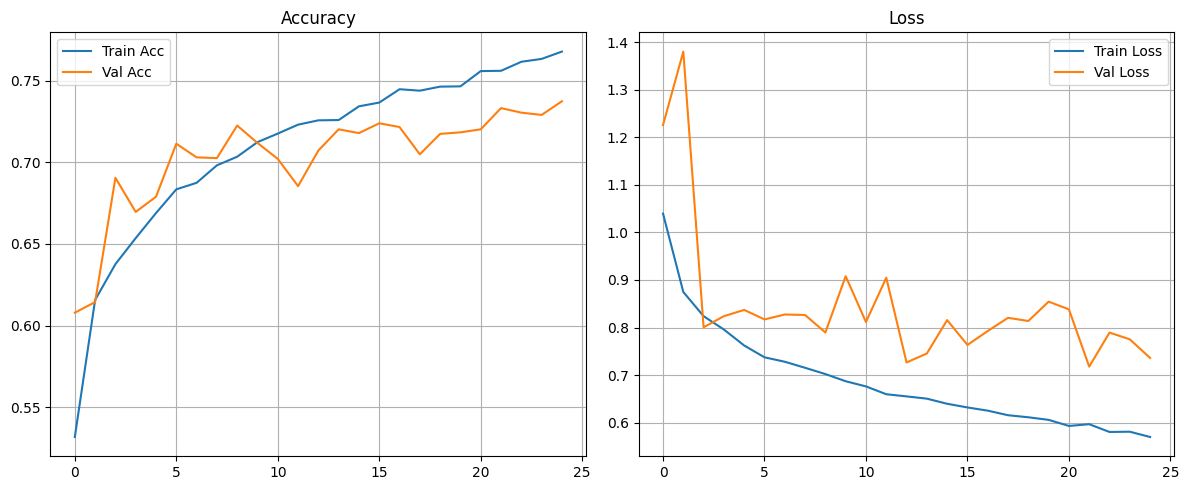

In [35]:
# 📊 Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_157']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step


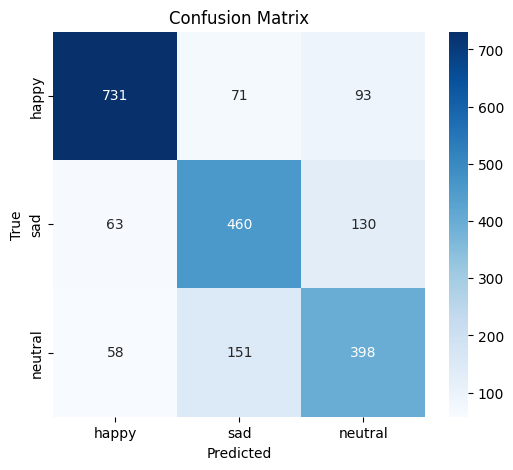

              precision    recall  f1-score   support

       happy       0.86      0.82      0.84       895
         sad       0.67      0.70      0.69       653
     neutral       0.64      0.66      0.65       607

    accuracy                           0.74      2155
   macro avg       0.72      0.73      0.72      2155
weighted avg       0.74      0.74      0.74      2155



In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 🧠 Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# 📊 Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['happy', 'sad', 'neutral'],
            yticklabels=['happy', 'sad', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 📝 Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=['happy', 'sad', 'neutral']))


In [ ]:
model.save("emotion_model_finetuned.keras")

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os

# Load FER2013 CSV
fer_csv_path = 'fer2013.csv'  # Put the correct path here
df = pd.read_csv(fer_csv_path)

# Create directory to save images
os.makedirs('fer2013_samples_3class', exist_ok=True)

# Mapping for your 3 classes
emotion_map = {3: 'Happy', 4: 'Sad', 6: 'Neutral'}

# Save first 5 images of each selected emotion as PNG
for emotion_idx in emotion_map.keys():
    # Filter rows for this emotion
    emotion_rows = df[df['emotion'] == emotion_idx].head(5)

    for i, (_, row) in enumerate(emotion_rows.iterrows()):
        pixels = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8)
        img_array = pixels.reshape(48, 48)

        # Save image as PNG
        img = Image.fromarray(img_array)
        img_path = f'fer2013_samples_3class/{emotion_map[emotion_idx]}_{i}.png'
        img.save(img_path)
        print(f'Saved {img_path}')



Saved fer2013_samples_3class/Happy_0.png
Saved fer2013_samples_3class/Happy_1.png
Saved fer2013_samples_3class/Happy_2.png
Saved fer2013_samples_3class/Happy_3.png
Saved fer2013_samples_3class/Happy_4.png
Saved fer2013_samples_3class/Sad_0.png
Saved fer2013_samples_3class/Sad_1.png
Saved fer2013_samples_3class/Sad_2.png
Saved fer2013_samples_3class/Sad_3.png
Saved fer2013_samples_3class/Sad_4.png
Saved fer2013_samples_3class/Neutral_0.png
Saved fer2013_samples_3class/Neutral_1.png
Saved fer2013_samples_3class/Neutral_2.png
Saved fer2013_samples_3class/Neutral_3.png
Saved fer2013_samples_3class/Neutral_4.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


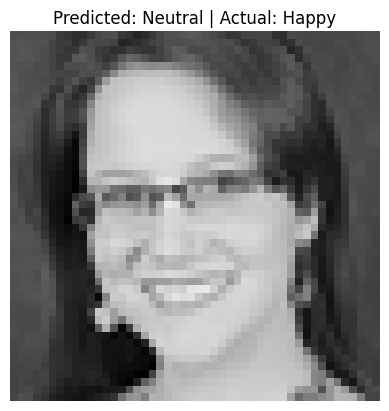

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


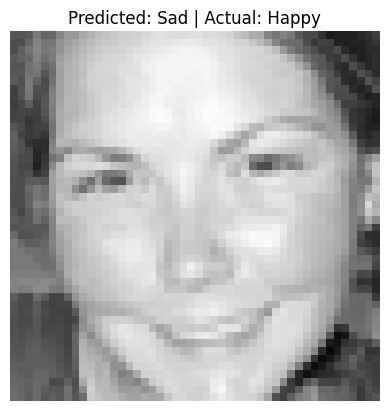

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


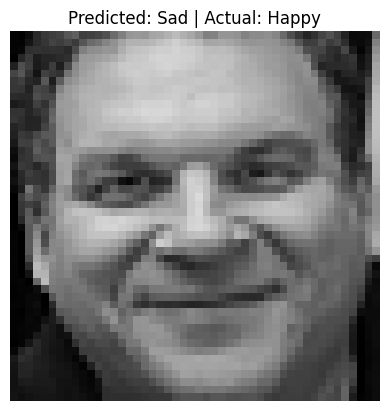

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


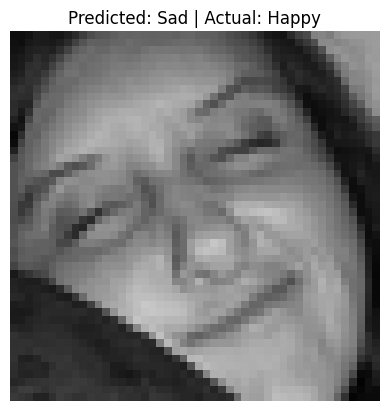

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


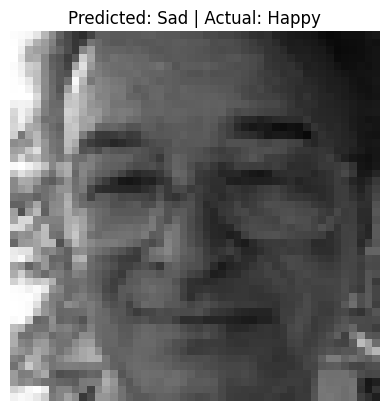

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


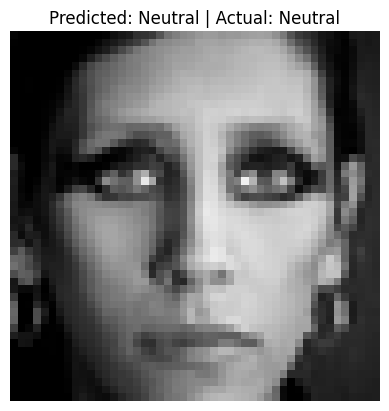

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


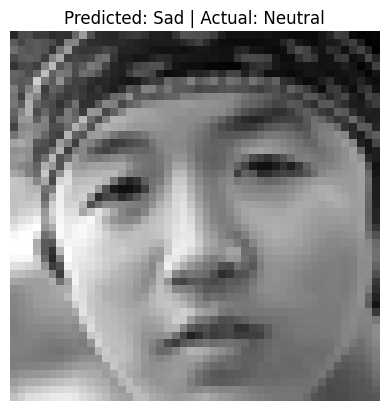

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


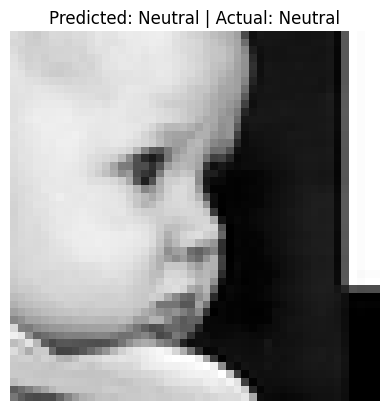

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


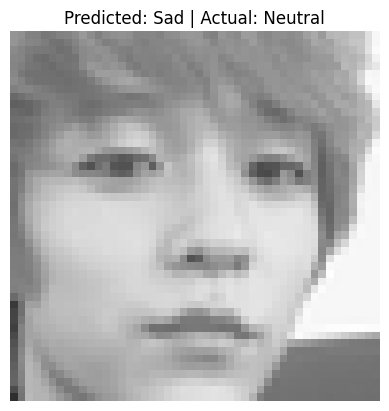

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


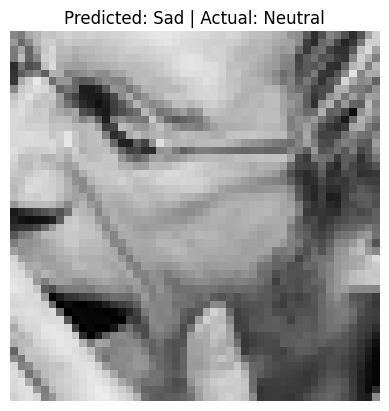

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


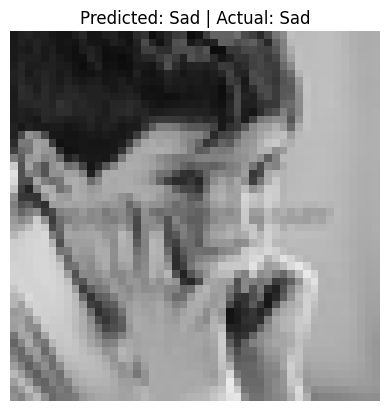

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


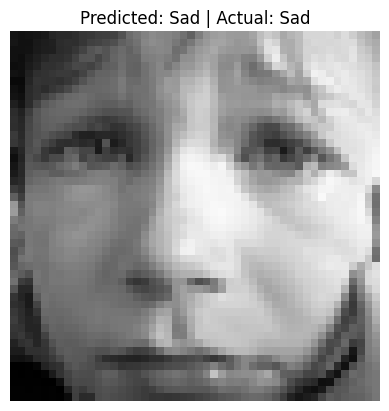

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


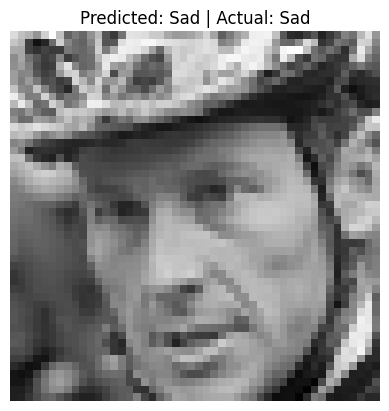

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


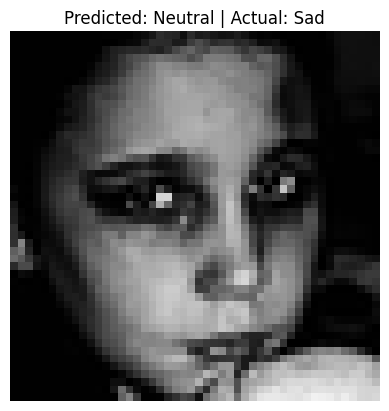

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


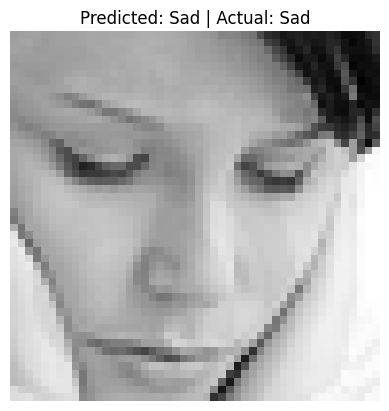

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Your class labels in the same order as the model output
emotion_labels = ['Happy', 'Sad', 'Neutral']

# Path to your images folder
sample_dir = "fer2013_samples_3class"

def preprocess_image(img_path):
    # Load as RGB if your model expects 3 channels
    img = image.load_img(img_path, color_mode="rgb", target_size=(48, 48))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def predict_emotion(model, img_path):
    processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction)
    predicted_label = emotion_labels[predicted_class]
    return predicted_label

# If you have ground truth labels encoded in filename (e.g. "Happy_0.png")
def get_actual_label(filename):
    for label in emotion_labels:
        if filename.startswith(label):
            return label
    return "Unknown"

# Iterate all images, predict, and display with actual label
for img_file in sorted(os.listdir(sample_dir)):
    img_path = os.path.join(sample_dir, img_file)
    predicted_label = predict_emotion(model, img_path)
    actual_label = get_actual_label(img_file)

    # Display image with matplotlib
    img = image.load_img(img_path, color_mode="rgb", target_size=(48, 48))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} | Actual: {actual_label}")
    plt.axis('off')
    plt.show()



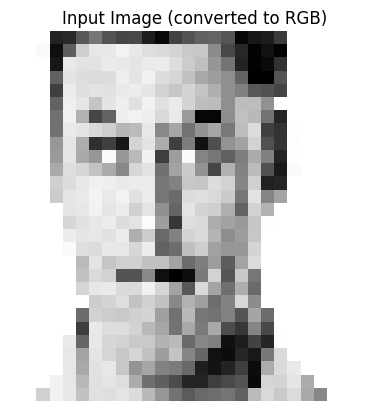

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted class: 0
Predicted emotion: happiness
Actual emotion: neutral


In [45]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define label mappings
INTERESTED_LABELS = [3, 4, 6]  # happiness, sadness, neutral
LABEL_MAP = {3:0, 4:1, 6:2}    # remap labels to 0,1,2
EMOTION_LABELS = {0: 'happiness', 1: 'sadness', 2: 'neutral'}

# Load and preprocess image - load as RGB instead of grayscale
img_path = 'black-and-white-male-headshot.png'
img = image.load_img(img_path, target_size=(28, 28), color_mode='rgb')  # Changed to 'rgb'
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values

# Show the image
plt.imshow(img_array)  # No need to squeeze for RGB
plt.title("Input Image (converted to RGB)")
plt.axis('off')
plt.show()

# Add batch dimension for model prediction
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
predicted_emotion = EMOTION_LABELS[predicted_class]
confidence = np.max(prediction) * 100

print(f"Predicted class: {predicted_class}")
print(f"Predicted emotion: {predicted_emotion}")
print("Actual emotion: neutral")
